In [16]:
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
plt.rc('figure',figsize=(16,4))
plt.rc('font',size=12)


# CMB-S4 Description

# # https://indico.cmb-s4.org/event/3/attachments/5/51/PBDR_v0.1.pdf Page 80 (SAT)
# freqs = np.array([30., 40., 85., 145., 95., 155., 220., 270.])
# fwhm = np.array([72.8, 72.8, 25.5, 25.5, 22.7, 22.7, 13, 13])
# dnu_nu = np.array([0.3, 0.3, 0.24, 0.22, 0.24, 0.22, 0.22, 0.22])
# net = np.array([177., 224., 270., 309., 238., 331., 747., 1281.])  #muk.sqrt(s)
# ndet = np.array([576, 576, 21144, 21144, 21144, 21144, 33752, 33752])
# CMB-S4 - private comm from Josquin (unofficial)
#7 years - 12 tubes - nominal 3% sky coverage
freqs = np.array([20., 30., 40., 85., 95., 145., 155., 220., 270.])
bandwidth = np.array([5., 9., 12., 20.4, 22.8, 31.9, 34.1, 48.4, 59.4])
dnu_nu = bandwidth/freqs
beam_fwhm = np.array([11., 72.8, 72.8, 25.5, 25.5, 22.7, 22.7, 13., 13.])
mukarcmin_TT = np.array([16.5, 9.36, 11.85, 2.02, 1.78, 3.89, 4.16, 10.15, 17.4])
mukarcmin_EE = np.array([10.87, 6.2, 7.85, 1.34, 1.18, 1.8, 1.93, 4.71, 8.08])
mukarcmin_BB = np.array([10.23, 5.85, 7.4, 1.27, 1.12, 1.76, 1.89, 4.6, 7.89])
ell_min = np.array([30, 30, 30, 30, 30, 30, 30, 30, 30])
nside = np.array([512, 512, 512, 512, 512, 512, 512, 512, 512])
edges_min = freqs * (1. - dnu_nu/2)
edges_max = freqs * (1. + dnu_nu/2)
edges = [[edges_min[i], edges_max[i]] for i in range(len(freqs))]
s4_config = {
    'nbands': len(freqs),
    'frequency': freqs,
    'depth_p': 0.5*(mukarcmin_EE + mukarcmin_BB),
    'depth_i': mukarcmin_TT,
    'depth_e': mukarcmin_EE,
    'depth_b': mukarcmin_BB,
    'fwhm': beam_fwhm,
    'bandwidth': bandwidth,
    'dnu_nu': dnu_nu,
    'ell_min': ell_min,
    'nside': nside,
    'fsky': 0.03,
    'ntubes': 12,
    'nyears': 7.,
    'edges': edges,
    'effective_fraction': np.zeros(len(freqs))+1.
            }


### QUBIC Sub-optimality : values from Louise Mousset's PhD thesis
def fct_subopt(nus):
    subnus = [150., 220]
    subval = [1.4, 1.2]
    fct_subopt = np.poly1d(np.polyfit(subnus, subval, 1))
    return fct_subopt(nus)

subnus = [150., 220]
subval = [1.4, 1.2]



def qubicify(config, qp_nsubs, qp_effective_fraction):
    nbands = np.sum(qp_nsubs)
    qp_config = config.copy()
    for k in qp_config.keys():
        qp_config[k]=[]
    qp_config['nbands'] = nbands
    qp_config['fsky'] = config['fsky']
    qp_config['ntubes'] = config['ntubes']
    qp_config['nyears'] = config['nyears']
    qp_config['initial_band'] = []
    
    for i in range(len(config['frequency'])):
        #print(config['edges'][i][0], config['edges'][i][-1])
        newedges = np.linspace(config['edges'][i][0], config['edges'][i][-1], qp_nsubs[i]+1)
        #print(newedges)
        newfreqs = (newedges[0:-1]+newedges[1:])/2
        newbandwidth = newedges[1:] - newedges[0:-1]
        newdnu_nu = newbandwidth / newfreqs
        newfwhm = config['fwhm'][i] * config['frequency'][i]/newfreqs
        scalefactor_noise = np.sqrt(qp_nsubs[i]) * fct_subopt(config['frequency'][i]) / qp_effective_fraction[i]
        newdepth_p = config['depth_p'][i] * np.ones(qp_nsub[i]) * scalefactor_noise
        newdepth_i = config['depth_i'][i] * np.ones(qp_nsub[i]) * scalefactor_noise
        newdepth_e = config['depth_e'][i] * np.ones(qp_nsub[i]) * scalefactor_noise
        newdepth_b = config['depth_b'][i] * np.ones(qp_nsub[i]) * scalefactor_noise
        newell_min = np.ones(qp_nsub[i]) * config['ell_min'][i]
        newnside = np.ones(qp_nsub[i]) * config['nside'][i]
        neweffective_fraction = np.ones(qp_nsub[i]) * qp_effective_fraction[i]
        initial_band = np.ones(qp_nsub[i]) * config['frequency'][i]
        
        for k in range(qp_nsubs[i]):
            if qp_effective_fraction[i] != 0:
                qp_config['frequency'].append(newfreqs[k])
                qp_config['depth_p'].append(newdepth_p[k])
                qp_config['depth_i'].append(newdepth_i[k])
                qp_config['depth_e'].append(newdepth_e[k])
                qp_config['depth_b'].append(newdepth_b[k])
                qp_config['fwhm'].append(newfwhm[k])
                qp_config['bandwidth'].append(newbandwidth[k])
                qp_config['dnu_nu'].append(newdnu_nu[k])
                qp_config['ell_min'].append(newell_min[k])
                qp_config['nside'].append(newnside[k])
                
                qp_config['effective_fraction'].append(neweffective_fraction[k])
                qp_config['initial_band'].append(initial_band[k])
        for k in range(qp_nsubs[i]+1):
            if qp_effective_fraction[i] != 0:
                qp_config['edges'].append(newedges[k])
    fields = ['frequency', 'depth_p', 'depth_i', 'depth_e', 'depth_b', 'fwhm', 'bandwidth', 
              'dnu_nu', 'ell_min', 'nside', 'edges', 'effective_fraction', 'initial_band']
    for j in range(len(fields)):
        qp_config[fields[j]] = np.array(qp_config[fields[j]])
        
    return qp_config

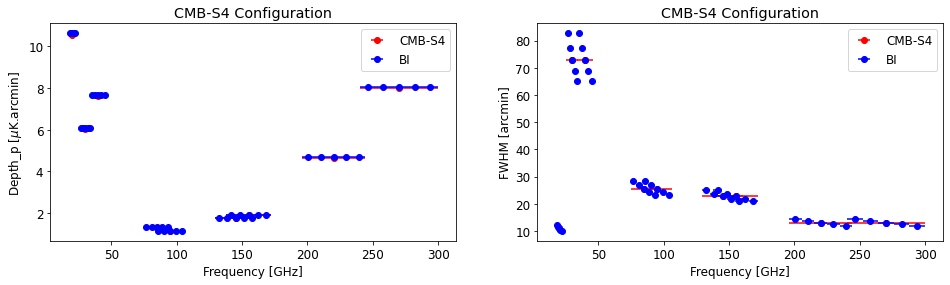

In [30]:
def give_me_frac(percent, nsub):
    fraction = np.ones(9)
    for i in range(9):
        frac = np.linspace(1,  np.sqrt(nsub)*fct_subopt(s4_config['frequency'][i]), 101)[::-1]
        #print(frac[percent])
        fraction[i] = frac[percent]
    #print(fraction)
    return fraction

percent=1

qp_nsub = np.array([5, 5, 5, 5, 5, 5, 5, 5, 5])
qp_effective_fraction = np.array([1., 1., 1., 1., 1., 1., 1., 1., 1.])*give_me_frac(percent, qp_nsub[0])
qp_config = qubicify(s4_config, qp_nsub, qp_effective_fraction)

plt.figure()
plt.subplot(1,2,1)
plt.errorbar(s4_config['frequency'], s4_config['depth_p'], xerr=s4_config['bandwidth']/2, fmt='ro', label='CMB-S4')
plt.errorbar(qp_config['frequency'], qp_config['depth_p'], xerr=qp_config['bandwidth']/2, fmt='bo', label='BI')
plt.xlabel('Frequency [GHz]')
plt.ylabel(r'Depth_p [$\mu$K.arcmin]')
plt.title('CMB-S4 Configuration')
plt.legend()
plt.subplot(1,2,2)
plt.errorbar(s4_config['frequency'], s4_config['fwhm'], xerr=s4_config['bandwidth']/2, fmt='ro', label='CMB-S4')
plt.errorbar(qp_config['frequency'], qp_config['fwhm'], xerr=qp_config['bandwidth']/2, fmt='bo', label='BI')
plt.xlabel('Frequency [GHz]')
plt.ylabel('FWHM [arcmin]')
plt.title('CMB-S4 Configuration')
plt.legend()
plt.show()

In [31]:
import s4bi
import matplotlib.pyplot as plt
from importlib import reload
from scipy import constants
from astropy.cosmology import Planck15
import qubic
from qubic import mcmc
import healpy as hp
import numpy as np
import os
import CMBS4
import qubicplus
#import fgbuster
import fgbuster
center = qubic.equ2gal(0, -57)
from fgbuster.component_model import (CMB, Dust, Dust_2b, Synchrotron, AnalyticComponent)
from fgbuster import basic_comp_sep, get_instrument
# If there is not this command, the kernel shut down every time..
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import pickle

# analytic expression 
analytic_expr=s4bi.double_beta_dust_FGB_Model()

betadown=1.64
betaup=1.44
beta1 = 1.54

def sed(analytic_expr, nus, beta0, beta1, nubreak, nu0, temp=20, hok=constants.h * 1e9 / constants.k):
    sed_expr = AnalyticComponent(analytic_expr, 
                             nu0=nu0, 
                             beta_d0=beta0, 
                             beta_d1=beta1, 
                             temp=temp,
                             nubreak=nubreak, 
                             h_over_k = hok)
    return nus, sed_expr.eval(nus)
nus=np.linspace(10, 400, 400)
nb=269
nu0=220
#nus, sed1b = sed(analytic_expr, nus, beta1, beta1, nubreak=nb, nu0=nu0)
#nus, sed2b = sed(analytic_expr, nus, betaup, betadown, nubreak=nb, nu0=nu0)

def get_coverage(fsky, nside, center_radec=[0., -57.]):
    center = qubic.equ2gal(center_radec[0], center_radec[1])
    uvcenter = np.array(hp.ang2vec(center[0], center[1], lonlat=True))
    uvpix = np.array(hp.pix2vec(nside, np.arange(12*nside**2)))
    ang = np.arccos(np.dot(uvcenter, uvpix))
    indices = np.argsort(ang)
    okpix = ang < -1
    okpix[indices[0:int(fsky * 12*nside**2)]] = True
    mask = np.zeros(12*nside**2)
    mask[okpix] = 1
    return mask

def separate(comp, instr, maps_to_separate, print_option=False):
    solver_options = {'eps':1e-5}
    solver_options['disp'] = False
    fg_args = comp, instr, maps_to_separate
    fg_kwargs = {'method': 'L-BFGS-B', 'options': solver_options}
    try:
        res = fgbuster.basic_comp_sep(*fg_args, **fg_kwargs)
    except KeyError:
        fg_kwargs['options']['disp'] = False
        res = fgbuster.basic_comp_sep(*fg_args, **fg_kwargs)
    if print_option:
        print()
        print("message:", res.message)
        print("success:", res.success)
        print("result:", res.x)
        
    return res

covmap = get_coverage(0.03, nside=256)
thr = 0.1
mymask = (covmap > (np.max(covmap)*thr)).astype(int)
pixok = mymask > 0

In [64]:
reload(qubicplus)

def run_mc(N, covmap, pixok, dict, name, nsub):
    
    inputs, inputs_noiseless, _  = qubicplus.BImaps({'cmb':42, 'dust':'d02b', 'synchrotron':'s0'}, dict).getskymaps(same_resol=0.1, 
                                                        iib=False, 
                                                        verbose=False, 
                                                        coverage=covmap, 
                                                        noise=True, 
                                                        signoise=1., 
                                                        beta=[betaup, betadown, nb, nu0])
    
    comp_modified = [Dust_2b(nu0=nu0, nubreak=nb), CMB(), Synchrotron(nu0=30)]
    comp_modified[0].defaults = [0.5, 0.5, 20]
    comp_modified[2].defaults = [-1]
    

    # Define instrument
    instr = get_instrument(name)
    instr.fwhm = np.ones(nsub)*0.1*60
    
    #Component Separation
    r=separate(comp_modified, instr, inputs[:, :, pixok])

    print("   beta_d0 = {:.6f} beta_d1 = {:.6f} T = {:.6f} beta_s = {:.6f}".format(r.x[0], r.x[1], r.x[2], r.x[3]))
    
    return r, inputs, inputs_noiseless

r, inputs, inputs_noiseless = run_mc(1, covmap, pixok, s4_config, 'CMBS4', 9)

> Modified Dust
> Synchrotron
   beta_d0 = 1.450901 beta_d1 = 0.545521 T = 20.048036 beta_s = -3.001056


In [65]:
rbi, inputsbi, inputsbi_noiseless = run_mc(1, covmap, pixok, qp_config, 'Qubic+', 45)

> Modified Dust
> Synchrotron
   beta_d0 = 1.438265 beta_d1 = 1.639286 T = 20.100150 beta_s = -3.000028


In [66]:
import pysm3
import pysm3.units as u
from pysm3 import utils

def give_me_sync_maps(nu_ref, betapl, nu0=nu0):
    analytic_expr_syn = '(nu / nu0)**(beta_pl)'
    sync = AnalyticComponent(analytic_expr_syn, nu0=nu0, beta_pl=betapl)
    scaling_factor_sync = sync.eval(nu_ref)
    #print(scaling_factor_sync)
    
    sky=pysm3.Sky(nside=256, preset_strings=['s0'])
    sync_map_ref = np.zeros((3, 12*256**2)) #this way the output is w/0 units!!
    sync_map_ref[0:3,:]=sky.get_emission(nu_ref*u.GHz).to(u.uK_CMB, equivalencies=u.cmb_equivalencies(nu_ref*u.GHz))

    map_test=sync_map_ref*scaling_factor_sync

    mask = s4bi.get_coverage(fsky=0.03, nside=256, center_radec=[0., -57.])
    #print(mask)

    return map_test


def give_me_allcomponents_maps(nu0, nb, beta0, beta1, T, betapl, pixok=pixok, fsky=0.03, nside=256, ref_fwhm=0.1):
    
    dust_maps = qubicplus.get_scaled_dust_dbmmb_map(nu_ref=nu0, nu_vec=[nu0], beta0=beta0, 
                                                    beta1=beta1, nubreak=nb, nside=nside, fsky=fsky, 
                                                        radec_center=[0., -57.], temp=T)
    
    sync_maps = give_me_sync_maps(nu_ref=nu0, betapl=betapl, nu0=nu0)
    
    sync_maps = hp.sphtfunc.smoothing(sync_maps, fwhm=np.deg2rad(ref_fwhm),verbose=False)
    dust_maps = hp.sphtfunc.smoothing(dust_maps[0], fwhm=np.deg2rad(ref_fwhm),verbose=False)
    
    sync_maps[:, ~pixok]=hp.UNSEEN
    dust_maps[:, ~pixok]=hp.UNSEEN
    
    return dust_maps, sync_maps

est_dust_maps, est_sync_maps = give_me_allcomponents_maps(nu0, nb, r.x[0], r.x[1], r.x[2], r.x[3])
true_dust_maps, true_sync_maps = give_me_allcomponents_maps(nu0, nb, betaup, betadown, 20, -3)


istk=1

cmbs4=qubicplus.BImaps({'cmb':42}, s4_config).get_cmb()

cmbs4 = hp.sphtfunc.smoothing(cmbs4, fwhm=np.deg2rad(0.1),verbose=False)
cmbs4[:, ~pixok] = hp.UNSEEN

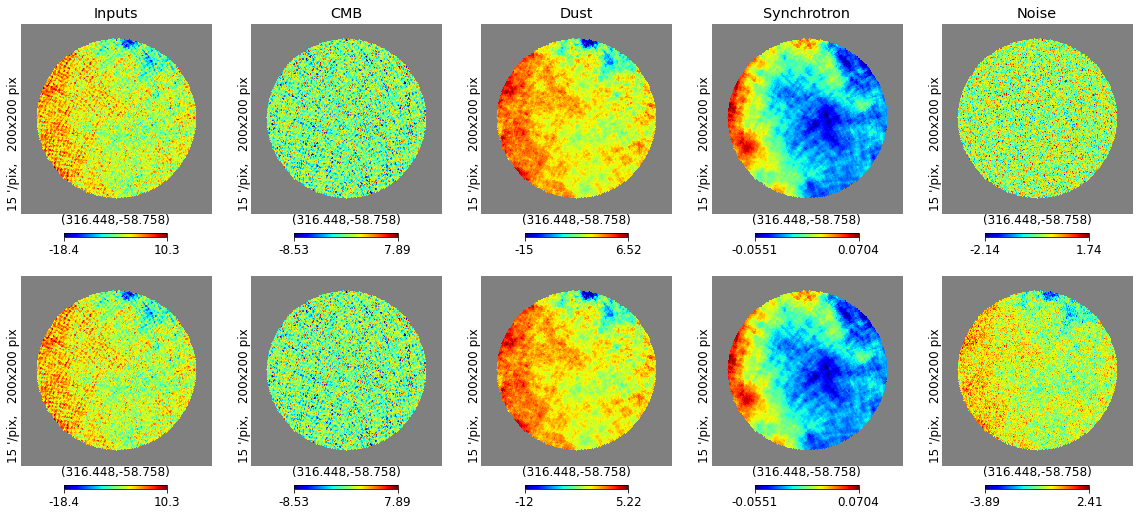

In [67]:
istk=2
plt.figure(figsize=(16, 7))
hp.gnomview(inputs[7, istk], rot=center, reso=15, sub=(2, 5, 1), title='Inputs', cmap='jet')
hp.gnomview(cmbs4[istk], rot=center, reso=15, sub=(2, 5, 2), title='CMB', cmap='jet')
hp.gnomview(true_dust_maps[istk], rot=center, reso=15, sub=(2, 5, 3), title='Dust', cmap='jet')
hp.gnomview(true_sync_maps[istk], rot=center, reso=15, sub=(2, 5, 4), title='Synchrotron', cmap='jet')
res_true = inputs[7, istk] - true_dust_maps[istk] - true_sync_maps[istk] - cmbs4[istk]
res_true[~pixok] = hp.UNSEEN
hp.gnomview(res_true, rot=center, reso=15, sub=(2, 5, 5), title='Noise', cmap='jet')


hp.gnomview(inputs[7, istk], rot=center, reso=15, sub=(2, 5, 6), title='', cmap='jet')
hp.gnomview(cmbs4[istk], rot=center, reso=15, sub=(2, 5, 7), title='', cmap='jet')
hp.gnomview(est_dust_maps[istk], rot=center, reso=15, sub=(2, 5, 8), title='', cmap='jet')
hp.gnomview(est_sync_maps[istk], rot=center, reso=15, sub=(2, 5, 9), title='', cmap='jet')
ress4=inputs[7, istk] - est_dust_maps[istk] - est_sync_maps[istk] - cmbs4[istk]
ress4[~pixok] = hp.UNSEEN
hp.gnomview(ress4, rot=center, reso=15, sub=(2, 5, 10), title='', cmap='jet')
plt.show()

In [68]:
## BI

est_bi_dust_maps, est_bi_sync_maps = give_me_allcomponents_maps(nu0, nb, rbi.x[0], rbi.x[1], rbi.x[2], rbi.x[3])
true_bi_dust_maps, true_bi_sync_maps = give_me_allcomponents_maps(nu0, nb, betaup, betadown, 20, -3)

cmbbi=qubicplus.BImaps({'cmb':42}, qp_config).get_cmb()

cmbbi = hp.sphtfunc.smoothing(cmbbi, fwhm=np.deg2rad(0.1),verbose=False)
cmbbi[:, ~pixok] = hp.UNSEEN

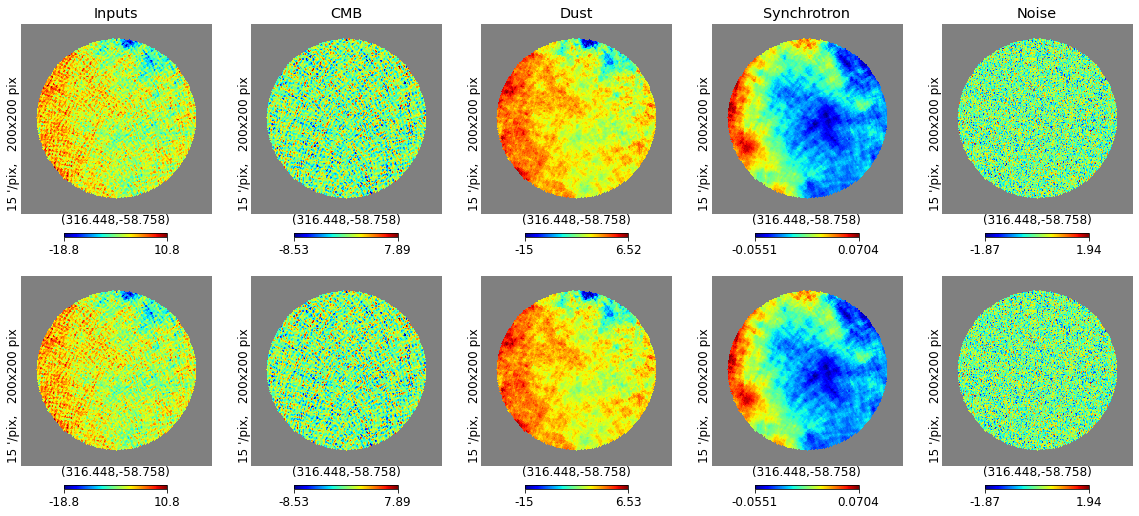

In [69]:
istk=2
plt.figure(figsize=(16, 7))
hp.gnomview(inputsbi[37, istk], rot=center, reso=15, sub=(2, 5, 1), cmap='jet', title='Inputs')
hp.gnomview(cmbbi[istk], rot=center, reso=15, sub=(2, 5, 2), cmap='jet', title='CMB')
hp.gnomview(true_bi_dust_maps[istk], rot=center, reso=15, sub=(2, 5, 3), cmap='jet', title='Dust')
hp.gnomview(true_bi_sync_maps[istk], rot=center, reso=15, sub=(2, 5, 4), cmap='jet', title='Synchrotron')
res_true = inputsbi[37, istk] - true_bi_dust_maps[istk] - true_bi_sync_maps[istk] - cmbbi[istk]
res_true[~pixok] = hp.UNSEEN
hp.gnomview(res_true, rot=center, reso=15, sub=(2, 5, 5), cmap='jet', title='Noise')


hp.gnomview(inputsbi[37, istk], rot=center, reso=15, sub=(2, 5, 6), cmap='jet', title='')
hp.gnomview(cmbbi[istk], rot=center, reso=15, sub=(2, 5, 7), cmap='jet', title='')
hp.gnomview(est_bi_dust_maps[istk], rot=center, reso=15, sub=(2, 5, 8), cmap='jet', title='')
hp.gnomview(est_bi_sync_maps[istk], rot=center, reso=15, sub=(2, 5, 9), cmap='jet', title='')
resbi=inputsbi[37, istk] - est_bi_dust_maps[istk] - est_bi_sync_maps[istk] - cmbbi[istk]
resbi[~pixok] = hp.UNSEEN
hp.gnomview(resbi, rot=center, reso=15, sub=(2, 5, 10), title='', cmap='jet')
plt.show()

# MC on fraction